#Step1: Dataset Integrity & Naive Baseline (MSLR-WEB10K)

Goal:
*   Correctly Load MSLR-WEB10K
*   Preserve Query Structure
*   Validate dataset intergrity
*   Train a naive LambdaMART baseline
* Report clean baseline NDCG scores





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import zipfile
import numpy as np
import pandas as pd


Mounted at /content/drive


In [ ]:
PROJECT_ROOT = "/content/drive/MyDrive/ltr-robustness"
ZIP_PATH = os.path.join(PROJECT_ROOT, "featureToRank/MSLR-WEB10K.zip")
LOCAL_DATA_DIR = "/content/mslr-web10k"

os.makedirs(LOCAL_DATA_DIR, exist_ok=True)

if not os.listdir(LOCAL_DATA_DIR):
    print("Extracting MSLR-WEB10K...")
    with zipfile.ZipFile(ZIP_PATH, "r") as zip_ref:
        zip_ref.extractall(LOCAL_DATA_DIR)
else:
    print("MSLR-WEB10K already extracted.")


Extracting MSLR-WEB10K...


In [ ]:
def load_letor_file(path, num_features=136):
    X, y, qids = [], [], []

    with open(path, "r") as f:
        for line in f:
            parts = line.strip().split()
            y.append(int(parts[0]))
            qids.append(int(parts[1].split(":")[1]))

            features = np.zeros(num_features)
            for p in parts[2:]:
                if ":" in p:
                    k, v = p.split(":")
                    features[int(k) - 1] = float(v)

            X.append(features)

    return np.array(X), np.array(y), np.array(qids)


In [ ]:
!ls /content/mslr-web10k/

Fold1  Fold2  Fold3  Fold4  Fold5


In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
from scipy.stats import describe

In [ ]:
def get_group_sizes(qids):
    groups, count = [], 1
    for i in range(1, len(qids)):
        if qids[i] == qids[i - 1]:
            count += 1
        else:
            groups.append(count)
            count = 1
    groups.append(count)
    return groups


In [ ]:
from sklearn.metrics import ndcg_score
from scipy.stats import kendalltau


In [ ]:
def compute_ndcg_at_k(y_true, y_score, qids, k):
    scores, start = [], 0
    for g in get_group_sizes(qids):
        end = start + g
        if g > 1:
            scores.append(
                ndcg_score([y_true[start:end]], [y_score[start:end]], k=k)
            )
        start = end
    return float(np.mean(scores))


In [ ]:
def compute_map(y_true, y_score, qids, relevance_threshold=1):
    ap_scores, start = [], 0
    for g in get_group_sizes(qids):
        end = start + g
        if g <= 1:
            start = end
            continue

        yq = y_true[start:end]
        sq = y_score[start:end]
        rel = (yq >= relevance_threshold).astype(int)

        if rel.sum() == 0:
            start = end
            continue

        order = np.argsort(-sq)
        hits, precisions = 0, []

        for i, idx in enumerate(order, 1):
            if rel[idx]:
                hits += 1
                precisions.append(hits / i)

        ap_scores.append(np.mean(precisions))
        start = end

    return float(np.mean(ap_scores))


In [ ]:
def compute_precision_at_k(y_true, y_score, qids, k, relevance_threshold=1):
    precisions, start = [], 0
    for g in get_group_sizes(qids):
        end = start + g
        if g > 1:
            order = np.argsort(-y_score[start:end])[:k]
            rel = (y_true[start:end][order] >= relevance_threshold).astype(int)
            precisions.append(np.mean(rel))
        start = end
    return float(np.mean(precisions))


In [ ]:
def add_gaussian_noise(X, sigma, seed=42):
    if sigma == 0.0:
        return X.copy()
    rng = np.random.default_rng(seed)
    return X + rng.normal(0, sigma, size=X.shape)

noise_levels = [0.0, 0.01, 0.05, 0.10, 0.20]


In [ ]:
def get_rankings_by_query(scores, qids):
    rankings, start = [], 0
    for g in get_group_sizes(qids):
        end = start + g
        if g > 1:
            rankings.append(np.argsort(-scores[start:end]))
        start = end
    return rankings


In [ ]:
def compute_kendall_tau(clean, noisy):
    taus = []
    for r1, r2 in zip(clean, noisy):
        tau, _ = kendalltau(r1, r2)
        if not np.isnan(tau):
            taus.append(tau)
    return float(np.mean(taus))


In [ ]:
def compute_kendall_tau_at_k(clean, noisy, k=10):
    taus = []
    for r1, r2 in zip(clean, noisy):
        if len(r1) < k:
            continue
        docs = r1[:k]
        pos1 = {d: i for i, d in enumerate(r1)}
        pos2 = {d: i for i, d in enumerate(r2)}
        tau, _ = kendalltau(
            [pos1[d] for d in docs],
            [pos2[d] for d in docs]
        )
        if not np.isnan(tau):
            taus.append(tau)
    return float(np.mean(taus))


In [ ]:
def compute_topk_overlap(clean, noisy, k=5):
    overlaps = []
    for r1, r2 in zip(clean, noisy):
        overlaps.append(len(set(r1[:k]) & set(r2[:k])) / k)
    return float(np.mean(overlaps))


We will also compute the MAP and Precision@K metrices, but these metrices would be considered as secondary and not the trend setters. These metrices we will add in a secondary table as a supporting evidences following the NDCG@K trend.

In [ ]:
def compute_pairwise_flip_rate(clean, noisy):
    rates = []
    for r1, r2 in zip(clean, noisy):
        pos1 = {d: i for i, d in enumerate(r1)}
        pos2 = {d: i for i, d in enumerate(r2)}
        flips, total = 0, 0
        for i in range(len(r1)):
            for j in range(i + 1, len(r1)):
                d1, d2 = r1[i], r1[j]
                total += 1
                if (pos1[d1] - pos1[d2]) * (pos2[d1] - pos2[d2]) < 0:
                    flips += 1
        rates.append(flips / total)
    return float(np.mean(rates))


In [ ]:
!pip install lightgbm
import lightgbm as lgb


In [ ]:
params = {
    "objective": "lambdarank",
    "metric": "ndcg",
    "ndcg_eval_at": [1, 3, 10],
    "learning_rate": 0.05,
    "num_leaves": 31,
    "min_data_in_leaf": 20,
    "verbosity": -1,
    "seed": 42
}

FOLDS = ["Fold1", "Fold2", "Fold3", "Fold4", "Fold5"]

phase2_rows, phase3_rows = [], []

for FOLD in FOLDS:
    print(f"\n===== {FOLD} =====")

    fold_dir = os.path.join(LOCAL_DATA_DIR, FOLD)

    X_train, y_train, qid_train = load_letor_file(os.path.join(fold_dir, "train.txt"))
    X_valid, y_valid, qid_valid = load_letor_file(os.path.join(fold_dir, "vali.txt"))
    X_test,  y_test,  qid_test  = load_letor_file(os.path.join(fold_dir, "test.txt"))

    train_groups = get_group_sizes(qid_train)
    valid_groups = get_group_sizes(qid_valid)

    lgb_train = lgb.Dataset(X_train, y_train, group=train_groups)
    lgb_valid = lgb.Dataset(X_valid, y_valid, group=valid_groups, reference=lgb_train)

    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=200,
        valid_sets=[lgb_valid],
        callbacks=[lgb.early_stopping(20)]
    )

    y_clean = model.predict(X_test)
    clean_rankings = get_rankings_by_query(y_clean, qid_test)

    # ---- Phase 2 ----
    for s in noise_levels:
        y_noisy = model.predict(add_gaussian_noise(X_test, s))
        phase2_rows.append({
            "fold": FOLD,
            "noise_sigma": s,
            "ndcg@10": compute_ndcg_at_k(y_test, y_noisy, qid_test, 10),
            "map": compute_map(y_test, y_noisy, qid_test),
            "precision@5": compute_precision_at_k(y_test, y_noisy, qid_test, 5)
        })

    # ---- Phase 3 ----
    for s in [0.01, 0.05, 0.10, 0.20]:
        y_noisy = model.predict(add_gaussian_noise(X_test, s))
        noisy_rankings = get_rankings_by_query(y_noisy, qid_test)

        phase3_rows.append({
            "fold": FOLD,
            "noise_sigma": s,
            "kendall_tau": compute_kendall_tau(clean_rankings, noisy_rankings),
            "kendall_tau@10": compute_kendall_tau_at_k(clean_rankings, noisy_rankings),
            "top5_overlap": compute_topk_overlap(clean_rankings, noisy_rankings),
            "pairwise_flip_rate": compute_pairwise_flip_rate(clean_rankings, noisy_rankings)
        })



===== Fold1 =====
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[80]	valid_0's ndcg@1: 0.500281	valid_0's ndcg@3: 0.477199	valid_0's ndcg@10: 0.496133

===== Fold2 =====
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[130]	valid_0's ndcg@1: 0.48649	valid_0's ndcg@3: 0.47587	valid_0's ndcg@10: 0.498564

===== Fold3 =====
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[90]	valid_0's ndcg@1: 0.49671	valid_0's ndcg@3: 0.477894	valid_0's ndcg@10: 0.49537

===== Fold4 =====
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[154]	valid_0's ndcg@1: 0.482833	valid_0's ndcg@3: 0.466229	valid_0's ndcg@10: 0.492225

===== Fold5 =====
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[137]	valid_0's ndcg@1: 0.496371	valid_0's ndcg@3: 0.481052	valid_0's ndcg@10: 

In [ ]:
phase2_df = pd.DataFrame(phase2_rows)
phase3_df = pd.DataFrame(phase3_rows)

phase2_summary = (
    phase2_df
    .drop(columns=["fold"])
    .groupby("noise_sigma")
    .agg(["mean", "std"])
)

phase3_summary = (
    phase3_df
    .drop(columns=["fold"])
    .groupby("noise_sigma")
    .agg(["mean", "std"])
)

OUT_DIR = os.path.join(PROJECT_ROOT, "results/lambdamart_all_folds")
os.makedirs(OUT_DIR, exist_ok=True)

phase2_df.to_csv(os.path.join(OUT_DIR, "phase2_all_folds.csv"), index=False)
phase3_df.to_csv(os.path.join(OUT_DIR, "phase3_all_folds.csv"), index=False)
phase2_summary.to_csv(os.path.join(OUT_DIR, "phase2_summary.csv"))
phase3_summary.to_csv(os.path.join(OUT_DIR, "phase3_summary.csv"))

print("DONE — all folds processed.")


DONE — all folds processed.


# Evaluating the same for XGBoost
* We run the same phases on XGboost.

In [ ]:
!pip install xgboost
import xgboost as xgb

In [ ]:
def train_xgboost_ranker(
    X_train, y_train, qid_train,
    X_valid, y_valid, qid_valid,
    num_rounds=200,
    seed=42
):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)

    dtrain.set_group(get_group_sizes(qid_train))
    dvalid.set_group(get_group_sizes(qid_valid))

    params = {
        "objective": "rank:ndcg",
        "eval_metric": "ndcg@10",
        "learning_rate": 0.05,
        "max_depth": 6,
        "min_child_weight": 20,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "seed": seed,
        "verbosity": 0
    }

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=num_rounds,
        evals=[(dvalid, "valid")],
        early_stopping_rounds=20,
        verbose_eval=False
    )

    return model


In [ ]:
FOLDS = ["Fold1", "Fold2", "Fold3", "Fold4", "Fold5"]

xgb_phase2_rows = []
xgb_phase3_rows = []

for FOLD in FOLDS:
    print(f"\n===== XGBoost | {FOLD} =====")

    fold_dir = os.path.join(LOCAL_DATA_DIR, FOLD)

    X_train, y_train, qid_train = load_letor_file(os.path.join(fold_dir, "train.txt"))
    X_valid, y_valid, qid_valid = load_letor_file(os.path.join(fold_dir, "vali.txt"))
    X_test,  y_test,  qid_test  = load_letor_file(os.path.join(fold_dir, "test.txt"))

    model = train_xgboost_ranker(
        X_train, y_train, qid_train,
        X_valid, y_valid, qid_valid
    )

    dtest = xgb.DMatrix(X_test)
    y_clean = model.predict(dtest)
    clean_rankings = get_rankings_by_query(y_clean, qid_test)

    # -------- Phase 2 --------
    for sigma in noise_levels:
        X_noisy = add_gaussian_noise(X_test, sigma)
        y_noisy = model.predict(xgb.DMatrix(X_noisy))

        xgb_phase2_rows.append({
            "model": "xgboost",
            "fold": FOLD,
            "noise_sigma": sigma,
            "ndcg@10": compute_ndcg_at_k(y_test, y_noisy, qid_test, 10),
            "map": compute_map(y_test, y_noisy, qid_test),
            "precision@5": compute_precision_at_k(y_test, y_noisy, qid_test, 5)
        })

    # -------- Phase 3 --------
    for sigma in [0.01, 0.05, 0.10, 0.20]:
        X_noisy = add_gaussian_noise(X_test, sigma)
        y_noisy = model.predict(xgb.DMatrix(X_noisy))
        noisy_rankings = get_rankings_by_query(y_noisy, qid_test)

        xgb_phase3_rows.append({
            "model": "xgboost",
            "fold": FOLD,
            "noise_sigma": sigma,
            "kendall_tau": compute_kendall_tau(clean_rankings, noisy_rankings),
            "kendall_tau@10": compute_kendall_tau_at_k(clean_rankings, noisy_rankings),
            "top5_overlap": compute_topk_overlap(clean_rankings, noisy_rankings),
            "pairwise_flip_rate": compute_pairwise_flip_rate(clean_rankings, noisy_rankings)
        })



===== XGBoost | Fold1 =====

===== XGBoost | Fold2 =====

===== XGBoost | Fold3 =====

===== XGBoost | Fold4 =====

===== XGBoost | Fold5 =====


In [ ]:
xgb_phase2_df = pd.DataFrame(xgb_phase2_rows)
xgb_phase3_df = pd.DataFrame(xgb_phase3_rows)

xgb_phase2_summary = (
    xgb_phase2_df
    .drop(columns=["fold", "model"])
    .groupby("noise_sigma")
    .agg(["mean", "std"])
)

xgb_phase3_summary = (
    xgb_phase3_df
    .drop(columns=["fold", "model"])
    .groupby("noise_sigma")
    .agg(["mean", "std"])
)


In [ ]:
OUT_DIR = os.path.join(PROJECT_ROOT, "results/xgboost_all_folds")
os.makedirs(OUT_DIR, exist_ok=True)

xgb_phase2_df.to_csv(os.path.join(OUT_DIR, "phase2_all_folds.csv"), index=False)
xgb_phase3_df.to_csv(os.path.join(OUT_DIR, "phase3_all_folds.csv"), index=False)
xgb_phase2_summary.to_csv(os.path.join(OUT_DIR, "phase2_summary.csv"))
xgb_phase3_summary.to_csv(os.path.join(OUT_DIR, "phase3_summary.csv"))

print("DONE — XGBoost all folds completed.")


DONE — XGBoost all folds completed.


In [27]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.figsize": (7, 5),
    "axes.grid": True,
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "legend.fontsize": 10
})


In [30]:
def plot_phase2_sensitivity(summary_df, title):
    noise = summary_df.index.values

    plt.figure()
    for metric in ["ndcg@10", "map", "precision@5"]:
        mean = summary_df[(metric, "mean")]
        std = summary_df[(metric, "std")]

        plt.errorbar(
            noise, mean, yerr=std,
            marker="o", capsize=3, label=metric
        )

    plt.xlabel("Noise σ")
    plt.ylabel("Metric value")
    plt.title(title)
    plt.legend()
    plt.show()


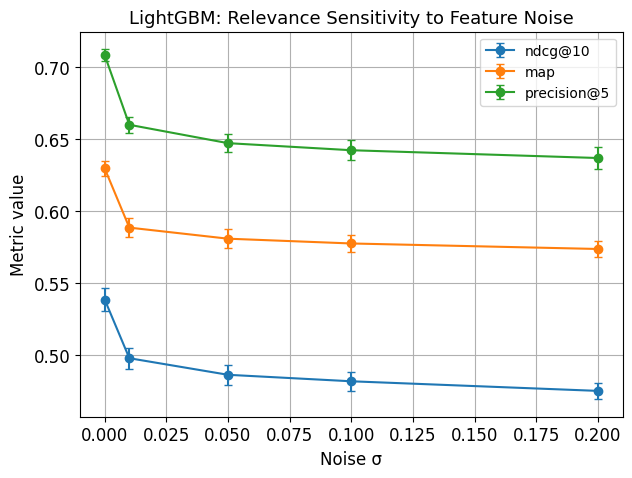

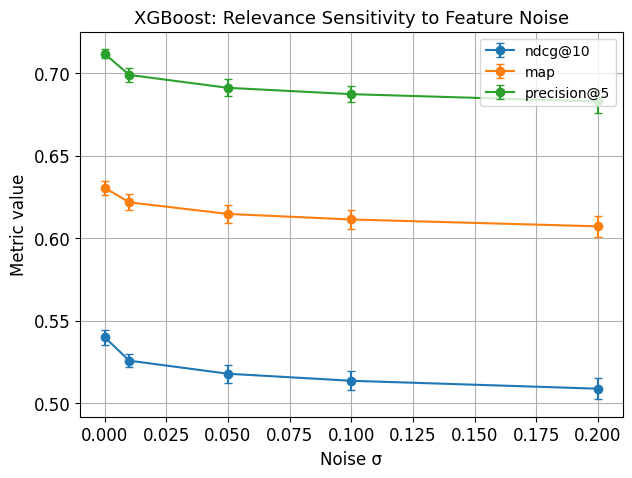

In [29]:
plot_phase2_sensitivity(
    phase2_summary,
    "LightGBM: Relevance Sensitivity to Feature Noise"
)

plot_phase2_sensitivity(
    xgb_phase2_summary,
    "XGBoost: Relevance Sensitivity to Feature Noise"
)


In [31]:
def plot_phase3_stability(summary_df, title):
    noise = summary_df.index.values

    plt.figure()
    for metric in ["kendall_tau", "kendall_tau@10", "top5_overlap"]:
        mean = summary_df[(metric, "mean")]
        std = summary_df[(metric, "std")]

        plt.errorbar(
            noise, mean, yerr=std,
            marker="o", capsize=3, label=metric
        )

    plt.xlabel("Noise σ")
    plt.ylabel("Stability score")
    plt.title(title)
    plt.legend()
    plt.show()


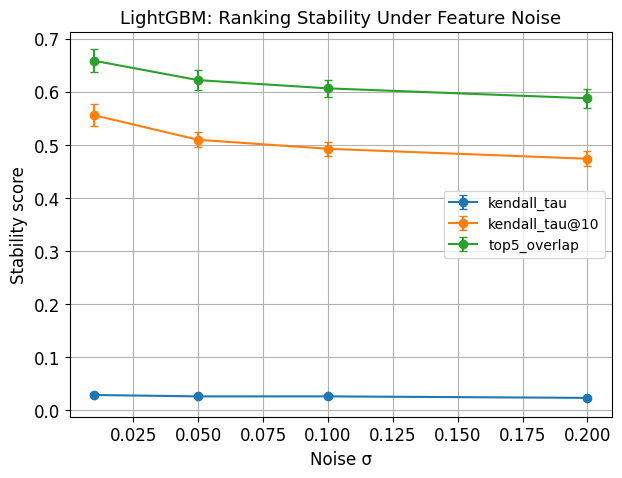

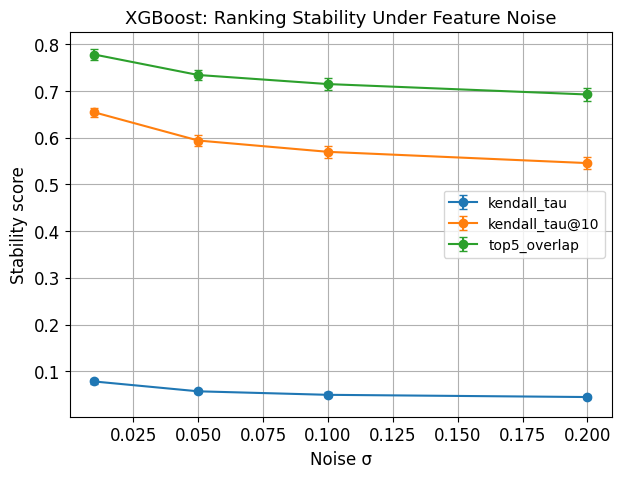

In [32]:
plot_phase3_stability(
    phase3_summary,
    "LightGBM: Ranking Stability Under Feature Noise"
)

plot_phase3_stability(
    xgb_phase3_summary,
    "XGBoost: Ranking Stability Under Feature Noise"
)


In [35]:
def plot_accuracy_vs_stability(summary_df, title):
    noise = summary_df.index.values

    fig, ax1 = plt.subplots()

    # ---- Accuracy (NDCG@10) ----
    ndcg_line, = ax1.plot(
        noise,
        summary_df[("ndcg@10", "mean")],
        marker="o",
        linestyle="-",
        color="tab:blue",
        label="NDCG@10 (Accuracy)"
    )
    ax1.set_xlabel("Noise σ")
    ax1.set_ylabel("NDCG@10", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    # ---- Stability (Kendall-τ@10) ----
    ax2 = ax1.twinx()
    tau_line, = ax2.plot(
        noise,
        summary_df[("kendall_tau@10", "mean")],
        marker="s",
        linestyle="--",
        color="tab:red",
        label="Kendall-τ@10 (Stability)"
    )
    ax2.set_ylabel("Kendall-τ@10", color="tab:red")
    ax2.tick_params(axis="y", labelcolor="tab:red")

    # ---- Combined legend ----
    ax1.legend(
        handles=[ndcg_line, tau_line],
        loc="best"
    )

    fig.suptitle(title)
    fig.tight_layout()
    plt.show()


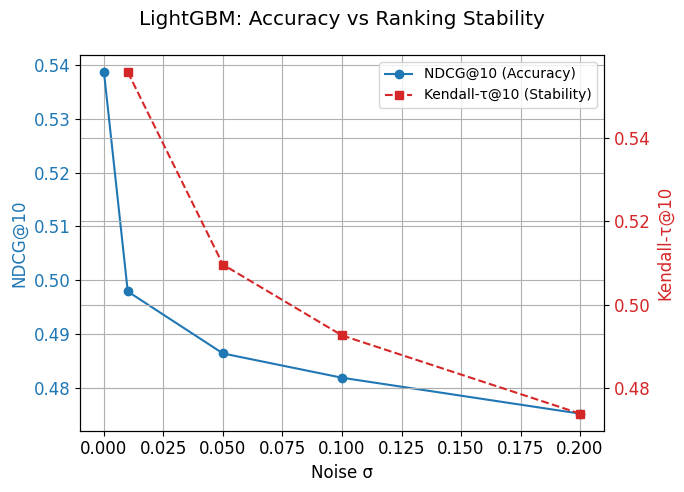

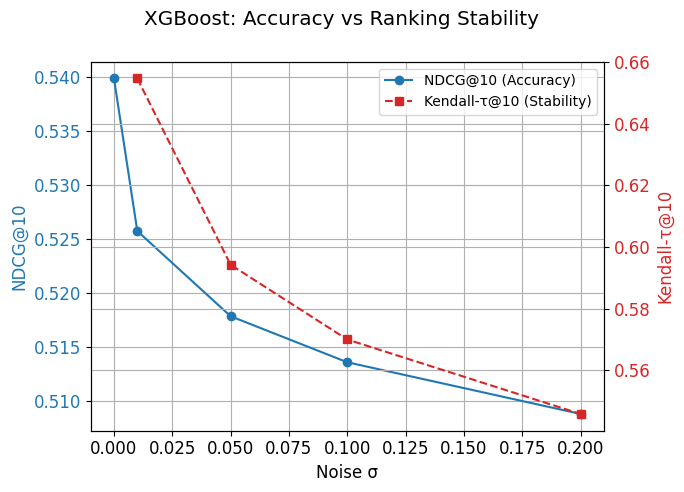

In [36]:
plot_accuracy_vs_stability(
    phase2_summary.join(phase3_summary),
    "LightGBM: Accuracy vs Ranking Stability"
)

plot_accuracy_vs_stability(
    xgb_phase2_summary.join(xgb_phase3_summary),
    "XGBoost: Accuracy vs Ranking Stability"
)


# We will run the same experiment on a new dataset MQ2008
* We will verify if the experiment is not dataset specific

In [37]:
!apt-get install -y unrar


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.


In [38]:
PROJECT_ROOT = "/content/drive/MyDrive/ltr-robustness"
MQ2008_RAR = os.path.join(PROJECT_ROOT, "featureToRank/MQ2008.rar")
MQ2008_DIR = "/content/mq2008"

import os
os.makedirs(MQ2008_DIR, exist_ok=True)

In [39]:
if not os.listdir(MQ2008_DIR):
    print("Extracting MQ2008 from RAR...")
    !unrar x "{MQ2008_RAR}" "{MQ2008_DIR}"
else:
    print("MQ2008 already extracted.")


Extracting MQ2008 from RAR...

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/ltr-robustness/featureToRank/MQ2008.rar

Creating    /content/mq2008/MQ2008                                    OK
Creating    /content/mq2008/MQ2008/Fold1                              OK
Extracting  /content/mq2008/MQ2008/Fold1/test.txt                          0%  1%  2%  OK 
Extracting  /content/mq2008/MQ2008/Fold1/train.txt                         2%  3%  4%  5%  6%  7%  8%  OK 
Extracting  /content/mq2008/MQ2008/Fold1/vali.txt                          9% 10%  OK 
Creating    /content/mq2008/MQ2008/Fold2                              OK
Extracting  /content/mq2008/MQ2008/Fold2/test.txt                         10% 11% 12%  OK 
Extracting  /content/mq2008/MQ2008/Fold2/train.txt                        12% 13% 14% 15% 16% 17% 18% 19%

In [40]:
!ls /content/mq2008


MQ2008


In [42]:
!ls /content/mq2008/MQ2008/Fold1

test.txt  train.txt  vali.txt


In [43]:
MQ2008_ROOT = "/content/mq2008/MQ2008"
FOLDS = ["Fold1", "Fold2", "Fold3", "Fold4", "Fold5"]

import lightgbm as lgb
import pandas as pd
import os


In [44]:
mq_phase2_rows = []
mq_phase3_rows = []


In [50]:
for FOLD in FOLDS:
    print(f"\n===== MQ2008 | LightGBM | {FOLD} =====")

    fold_dir = os.path.join(MQ2008_ROOT, FOLD)

    # Load data
    X_train, y_train, qid_train = load_letor_file(os.path.join(fold_dir, "train.txt"))
    X_valid, y_valid, qid_valid = load_letor_file(os.path.join(fold_dir, "vali.txt"))
    X_test,  y_test,  qid_test  = load_letor_file(os.path.join(fold_dir, "test.txt"))

    # Group sizes
    train_groups = get_group_sizes(qid_train)
    valid_groups = get_group_sizes(qid_valid)

    # LightGBM datasets
    lgb_train = lgb.Dataset(
        X_train,
        label=y_train,
        group=train_groups,
        free_raw_data=False
    )

    lgb_valid = lgb.Dataset(
        X_valid,
        label=y_valid,
        group=valid_groups,
        reference=lgb_train,
        free_raw_data=False
    )

    # Train model
    model = lgb.train(
    params,
    lgb_train,
    num_boost_round=200,
    valid_sets=[lgb_valid],
    callbacks=[
        lgb.early_stopping(stopping_rounds=20),
        lgb.log_evaluation(period=0)  # disables logging
    ]
)

    # Clean predictions
    y_clean = model.predict(X_test)
    clean_rankings = get_rankings_by_query(y_clean, qid_test)

    # -------------------------
    # Phase 2: Sensitivity
    # -------------------------
    for sigma in noise_levels:
        X_noisy = add_gaussian_noise(X_test, sigma)
        y_noisy = model.predict(X_noisy)

        mq_phase2_rows.append({
            "dataset": "MQ2008",
            "model": "lightgbm",
            "fold": FOLD,
            "noise_sigma": sigma,
            "ndcg@10": compute_ndcg_at_k(y_test, y_noisy, qid_test, 10),
            "map": compute_map(y_test, y_noisy, qid_test),
            "precision@5": compute_precision_at_k(y_test, y_noisy, qid_test, 5)
        })

    # -------------------------
    # Phase 3: Stability
    # -------------------------
    for sigma in [0.01, 0.05, 0.1, 0.2]:
        X_noisy = add_gaussian_noise(X_test, sigma)
        y_noisy = model.predict(X_noisy)

        noisy_rankings = get_rankings_by_query(y_noisy, qid_test)

        mq_phase3_rows.append({
            "dataset": "MQ2008",
            "model": "lightgbm",
            "fold": FOLD,
            "noise_sigma": sigma,
            "kendall_tau": compute_kendall_tau(clean_rankings, noisy_rankings),
            "kendall_tau@10": compute_kendall_tau_at_k(clean_rankings, noisy_rankings),
            "top5_overlap": compute_topk_overlap(clean_rankings, noisy_rankings),
            "pairwise_flip_rate": compute_pairwise_flip_rate(clean_rankings, noisy_rankings)
        })



===== MQ2008 | LightGBM | Fold1 =====
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[11]	valid_0's ndcg@1: 0.679406	valid_0's ndcg@3: 0.70017	valid_0's ndcg@10: 0.78876

===== MQ2008 | LightGBM | Fold2 =====
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	valid_0's ndcg@1: 0.690171	valid_0's ndcg@3: 0.745698	valid_0's ndcg@10: 0.80746

===== MQ2008 | LightGBM | Fold3 =====
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[4]	valid_0's ndcg@1: 0.66242	valid_0's ndcg@3: 0.721839	valid_0's ndcg@10: 0.79373

===== MQ2008 | LightGBM | Fold4 =====
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[4]	valid_0's ndcg@1: 0.658174	valid_0's ndcg@3: 0.661945	valid_0's ndcg@10: 0.757457

===== MQ2008 | LightGBM | Fold5 =====
Training until validation scores don't improve for 20 rounds
Early stopping, best

In [51]:
mq_phase2_df = pd.DataFrame(mq_phase2_rows)
mq_phase3_df = pd.DataFrame(mq_phase3_rows)


In [52]:
mq_phase2_summary = (
    mq_phase2_df
    .drop(columns=["dataset", "model", "fold"])
    .groupby("noise_sigma")
    .agg(["mean", "std"])
)

mq_phase3_summary = (
    mq_phase3_df
    .drop(columns=["dataset", "model", "fold"])
    .groupby("noise_sigma")
    .agg(["mean", "std"])
)


In [53]:
OUT_DIR = "/content/drive/MyDrive/ltr-robustness/results/mq2008_lightgbm"
os.makedirs(OUT_DIR, exist_ok=True)

mq_phase2_df.to_csv(os.path.join(OUT_DIR, "phase2_all_folds.csv"), index=False)
mq_phase3_df.to_csv(os.path.join(OUT_DIR, "phase3_all_folds.csv"), index=False)
mq_phase2_summary.to_csv(os.path.join(OUT_DIR, "phase2_summary.csv"))
mq_phase3_summary.to_csv(os.path.join(OUT_DIR, "phase3_summary.csv"))

print("DONE — MQ2008 LightGBM all folds completed.")


DONE — MQ2008 LightGBM all folds completed.


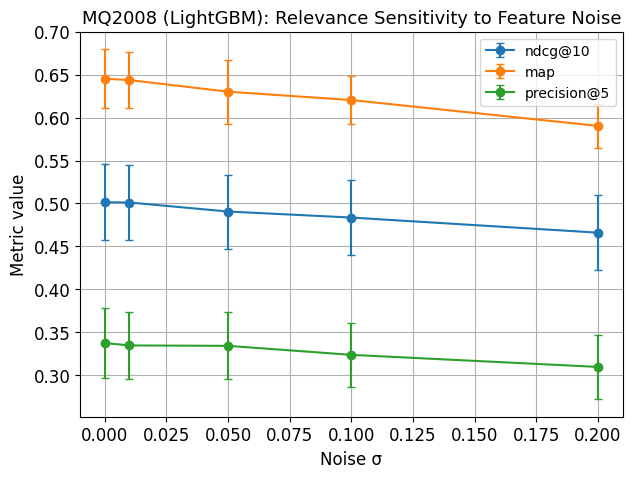

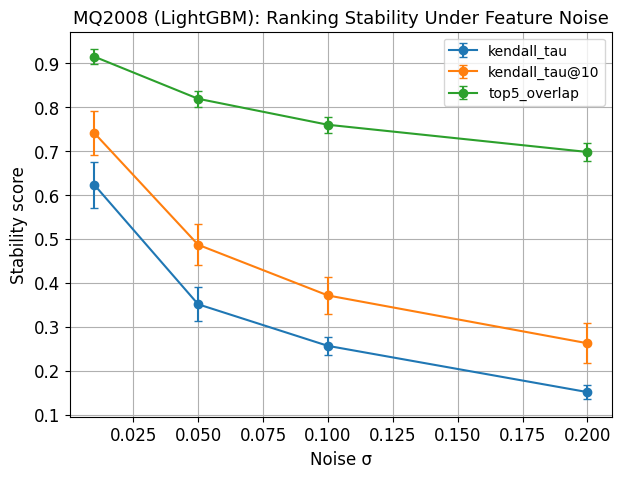

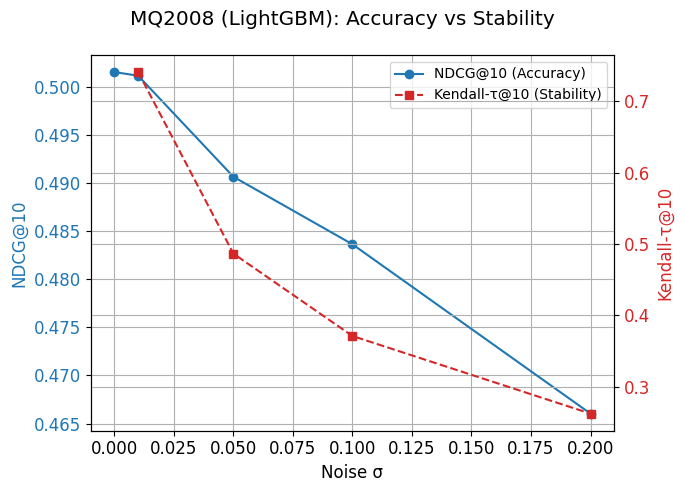

In [54]:
plot_phase2_sensitivity(
    mq_phase2_summary,
    "MQ2008 (LightGBM): Relevance Sensitivity to Feature Noise"
)

plot_phase3_stability(
    mq_phase3_summary,
    "MQ2008 (LightGBM): Ranking Stability Under Feature Noise"
)

plot_accuracy_vs_stability(
    mq_phase2_summary.join(mq_phase3_summary),
    "MQ2008 (LightGBM): Accuracy vs Stability"
)
